**Traffic Sign Recognition**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

**Seperating of labels and images**

In [ ]:
X = [] #images stored as np array
y = [] #class labels (0 to 42)

classes = 43

for i in range(classes):
    path = os.path.join('/content/My Drive/datasets/gtsrb-german-traffic-sign/Train/',str(i)+'/')
    images = os.listdir(path)
    
    for img_name in images:
        image = Image.open(path +img_name)
        image = image.resize((30, 30))
        image = np.array(image)
        X.append(image)
        y.append(i)
        
X = np.array(X)
y = np.array(y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

**conv1 -> conv2 -> maxpool1 -> dropout1 -> conv3 -> conv4 -> maxpool2 -> dropout2 -> fc1 -> dropout3 -> fc2 -> linear**

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5) #output (26,26,32)
        self.conv2 = nn.Conv2d(32, 32, 5) #output (22,22,32)
        self.pool1 = nn.MaxPool2d(2,2) #output (11,11,32)
        self.dropout1 = nn.Dropout(0.25) #output (11,11,32)
        self.conv3 = nn.Conv2d(32, 64, 3) #output(9,9,64)
        self.conv4 = nn.Conv2d(64, 64, 3) #output (7,7,64)
        self.pool2 = nn.MaxPool2d(2,2)  #output (3,3,64)
        self.dropout2 = nn.Dropout(0.25) #output (3,3,64)
        self.fc1 = nn.Linear(3*3*64,256) #output (256, 1)
        self.dropout3 = nn.Dropout(0.5) #output (256, 1)
        self.fc2 = nn.Linear(256, 43) #output (43, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [ ]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=43, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

**Transformation of images into tensor**

In [ ]:
X_train_tensor = torch.from_numpy(np.transpose(X_train, (0, 3, 1, 2))).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_val_tensor = torch.from_numpy(np.transpose(X_test, (0, 3, 1, 2))).float()
y_val_tensor = torch.from_numpy(y_test).long()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(dataset=train_data, batch_size=64)
val_dataloader = DataLoader(dataset=val_data, batch_size=64)
dataloaders = {'train': train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train': len(X_train), 'val': len(X_test)}

**Training**

In [ ]:
def train_model(model, criterion, optimizer, dataset_sizes, num_epochs=15):
    
    since = time.time()
    epoch_loss = []
    epoch_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            i = 0
            running_loss = 0.0
            running_corrects = 0
            
            if phase == 'train':
                 print(f'\rProgress:',end='')
                       
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and i % 50 == 49:
                    print(f"\rProgress: [{'='*((i+1)//50)}] ",end='')
                i += 1
                                  
            epoch_loss.append(running_loss / dataset_sizes[phase])
            epoch_acc.append(running_corrects.numpy() / dataset_sizes[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss[-1], epoch_acc[-1]))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return epoch_loss, epoch_acc

In [ ]:
epoch_loss, epoch_acc = train_model(model, criterion, optimizer, dataset_sizes, num_epochs=15)

Epoch 0/14
----------
Progress: [=========] train Loss: 0.0297 Acc: 0.4922
val Loss: 0.0117 Acc: 0.8128

Epoch 1/14
----------
Progress: [=========] train Loss: 0.0138 Acc: 0.7389
val Loss: 0.0073 Acc: 0.8863

Epoch 2/14
----------
Progress: [=========] train Loss: 0.0109 Acc: 0.7919
val Loss: 0.0048 Acc: 0.9157

Epoch 3/14
----------
Progress: [=========] train Loss: 0.0096 Acc: 0.8151
val Loss: 0.0040 Acc: 0.9245

Epoch 4/14
----------
Progress: [=========] train Loss: 0.0088 Acc: 0.8283
val Loss: 0.0035 Acc: 0.9288

Epoch 5/14
----------
Progress: [=========] train Loss: 0.0081 Acc: 0.8422
val Loss: 0.0032 Acc: 0.9375

Epoch 6/14
----------
Progress: [=========] train Loss: 0.0075 Acc: 0.8510
val Loss: 0.0031 Acc: 0.9389

Epoch 7/14
----------
Progress: [=========] train Loss: 0.0073 Acc: 0.8593
val Loss: 0.0025 Acc: 0.9513

Epoch 8/14
----------
Progress: [=========] train Loss: 0.0069 Acc: 0.8657
val Loss: 0.0026 Acc: 0.9505

Epoch 9/14
----------
Progress: [=========] train Loss:

In [ ]:
accuracy = epoch_acc[::2]
val_accuracy = epoch_acc[1::2]
loss = epoch_loss[::2]
val_loss = epoch_loss[1::2]

**Plotting Training and Validation Accuracy**

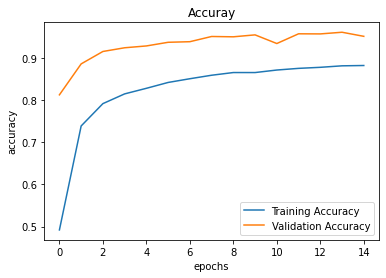

In [ ]:
plt.figure()
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.title('Accuray')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


**Plotting Training and Validation Losses**

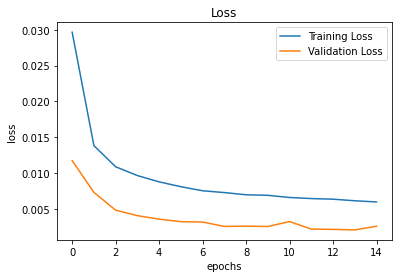

In [ ]:
plt.figure()
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


**Saving model**

In [ ]:
torch.save(model.state_dict(), 'model.pt')

**loading model**

In [ ]:
py_model=Net()
py_model.load_state_dict(torch.load('model.pt'))

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=43, bias=True)
)

**Testing**

In [ ]:
N = 5000
import pandas as pd
test_model_data = pd.read_csv('/content/My Drive/datasets/gtsrb-german-traffic-sign/Test.csv')

y_test_labels = test_model_data['ClassId'][:N]
img_paths = test_model_data['Path'][:N]
x_test_labels = []
path="/content/My Drive/datsets/gtsrb-german-traffic-sign/"
#read images from disk
for img in img_paths:
    image = Image.open(path+img)
    image = image.resize((30,30))
    image=np.array(image)    
    x_test_labels.append(image)
    
x_test_labels = np.array(x_test_labels)

In [ ]:
X_test_labels_tensor = torch.from_numpy(np.transpose(x_test_labels, (0, 3, 1, 2))).float()
y_test_labels_tensor = torch.from_numpy(y_test_labels.values).long()
print(X_test_labels_tensor.shape)

torch.Size([5000, 3, 30, 30])


**Evaluation**

In [ ]:
model.eval()
y_test_outputs = model(X_test_labels_tensor)
_, y_test_preds = torch.max(y_test_outputs, 1)
print(y_test_preds.numpy())
acc = torch.sum(y_test_preds == y_test_labels_tensor.data).float()/len(y_test_labels)
print(f"{acc:.2%}")

[16  1 38 ...  4  3 35]
90.40%
